# Complete Processing and Model Development for COVID Data

## Dependencies

In [104]:
!pip install deap graphviz

## Imports

In [233]:
# data manipulation
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import pairwise_distances
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from dtw import dtw

# models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, RidgeClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import BayesianRidge

# data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
from sklearn.tree import plot_tree, export_graphviz

# evaluation
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score
from sklearn.inspection import partial_dependence, PartialDependenceDisplay, permutation_importance
from sklearn.feature_selection import mutual_info_classif
import shap

# hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold, RepeatedStratifiedKFold

# type checking
from typing import Dict

# ARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# evolutionary optimisation
import random
from thresholding import *

# statistical metrics
from scipy import stats
from scipy.fft import fft
from scipy.stats import kurtosis, skew, entropy, linregress, zscore, skew, kurtosis, shapiro
from scipy.spatial import distance

# other
from functools import partial

In [2]:
np.random.seed(42)
random.seed(42)

In [235]:
import warnings
warnings.filterwarnings('ignore')

## Data Download

### For EDA

In [3]:
covid_df = pd.read_csv("./data/ingested/covid_timeseries_data.csv")

In [4]:
covid_timeseries = covid_df.groupby(['sample']).apply(
    lambda x: x.sort_values('mins')['value'].values,
    include_groups=False
)

In [5]:
covid_outcomes = covid_df.groupby(['sample']).apply(
    lambda x: x['result'].values[0],
    include_groups = False
)

### For implementation

In [3]:
covid_df : pd.DataFrame = pd.read_csv("./data/ingested/covid_timeseries_data.csv")

In [4]:
# normalisation
covid_timeseries = covid_df.groupby(['sample']).apply(
    lambda x: (
        (x.sort_values('mins')['value'].values - x['value'].min()) /
        (x['value'].max() - x['value'].min())
    ),
    include_groups=False
)

# standardisation
# covid_timeseries = covid_df.groupby(['sample']).apply(
#     lambda x: (
#         (x.sort_values('mins')['value'].values - x['value'].mean()) /
#         x['value'].std()
#     ),
#     include_groups=False
# )

In [5]:
covid_outcomes = covid_df.groupby(['sample']).apply(
    lambda x: x['result'].values[0],
    include_groups = False
)

## Exploratory Data Analysis

### Train-test splitting to avoid data leakage

In [47]:
covid_data = pd.merge(covid_timeseries.to_frame(name='timeseries'),
                         covid_outcomes.to_frame(name='result'), on=['sample'], how='left')

In [119]:
y = covid_data['result']
X = covid_data.drop('result', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42, stratify=y_train)

In [49]:
print("Number of total entries: {}".format(len(X_train)+len(X_val)+len(X_test)))
print("Number of entries in training set: {}".format(len(X_train)))
print("Number of entries in validation set: {}".format(len(X_val)))
print("Number of entries in testing set: {}".format(len(X_test)))

Number of total entries: 278
Number of entries in training set: 194
Number of entries in validation set: 28
Number of entries in testing set: 56


### Preparing the training data

**Curves without normalisation**

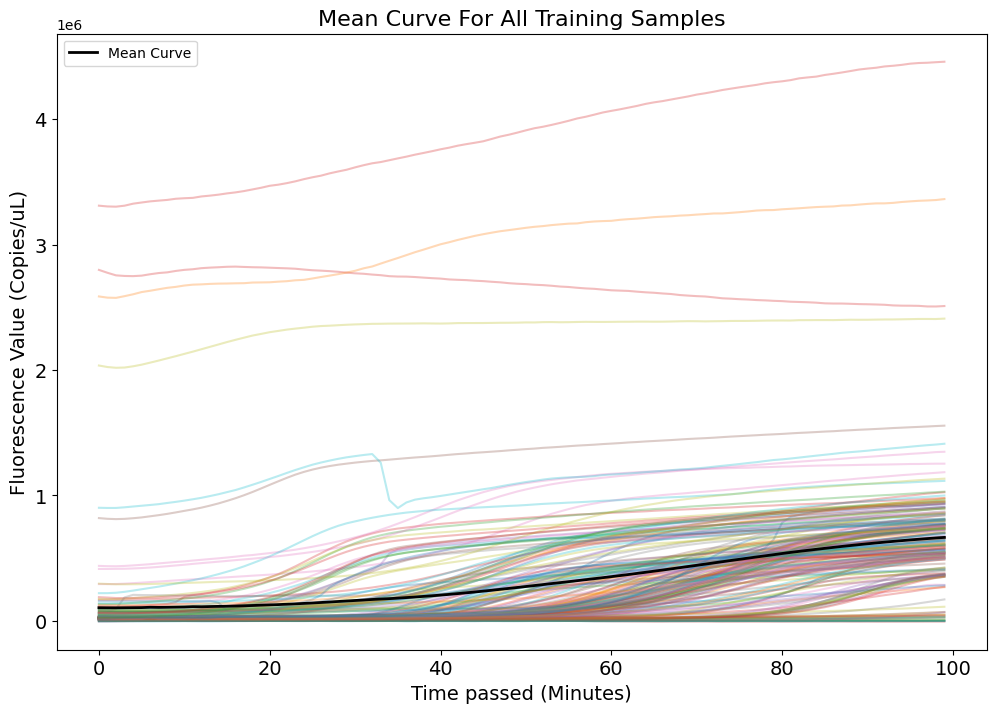

In [50]:
covid_sequences_array = np.vstack(X_train['timeseries'].values)

covid_mean_curve = np.mean(covid_sequences_array, axis=0)

plt.figure(figsize=(12, 8))
for series in X_train['timeseries']:
    plt.plot(series, alpha=0.3)
plt.plot(covid_mean_curve, color='black', linewidth=2, label='Mean Curve')
plt.legend()
plt.title("Curves For All Training Samples", fontsize=16)
plt.xlabel('Time passed (Minutes)', fontsize=14)
plt.ylabel('Fluorescence Value (Copies/uL)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

**Normalisation**

In [120]:
X_train['timeseries'] = X_train['timeseries'].apply(lambda x: (np.array(x) - np.min(x)) / (np.max(x) - np.min(x)) if len(x) > 1 else x)

**Standardisation**

In [104]:
#X_train['timeseries'] = X_train['timeseries'].apply(lambda x: (np.array(x) - np.mean(x)) / np.std(x) if len(x) > 1 else x)

### Checking for missing values, duplicates, and basic stats

Missing values

In [81]:
print("Number of entries with missing values:", X_train.isna().sum())
print("Number of duplicates present:", X_train.duplicated().sum())

Number of entries with missing values: timeseries    0
dtype: int64
Number of duplicates present: 0


### Checking timeseries lengths

In [57]:
covid_lengths = {}
for timeseries in X_train['timeseries']:
    if len(timeseries) in covid_lengths:
        covid_lengths[len(timeseries)] += 1
    else:
        covid_lengths[len(timeseries)] = 0

covid_lengths

{100: 193}

As shown above, all 193 entries have a length of 100 data points - with each data point translating to 1 minute.

### Visualising the curves

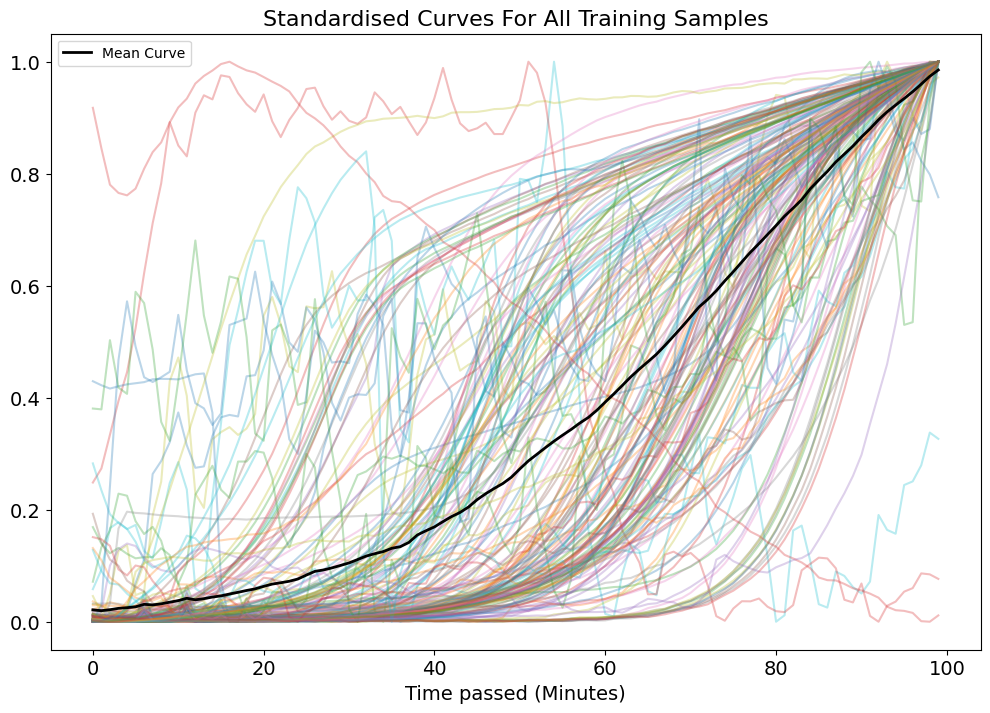

In [121]:
covid_sequences_array = np.vstack(X_train['timeseries'].values)

covid_mean_curve = np.mean(covid_sequences_array, axis=0)

plt.figure(figsize=(12, 8))
for series in X_train['timeseries']:
    plt.plot(series, alpha=0.3)
plt.plot(covid_mean_curve, color='black', linewidth=2, label='Mean Curve')
plt.legend()
plt.title("Standardised Curves For All Training Samples", fontsize=16)
plt.xlabel('Time passed (Minutes)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

#### Outlier removal

In [122]:
def extract_metrics(series):
    diff = np.diff(series)
    return {
        'std': np.std(series),
        'mean_abs_change': np.mean(np.abs(diff)),
        'autocorr': pd.Series(series).autocorr(lag=1)
    }

metrics_df = pd.DataFrame([
    extract_metrics(ts) for ts in X_train['timeseries']
])

outlier_flags = (np.abs(zscore(metrics_df)) > 3).any(axis=1)
metric_outliers = metrics_df[outlier_flags]

In [123]:
def total_variation(series):
    return np.sum(np.abs(np.diff(series)))

tv_scores = [total_variation(ts) for ts in X_train['timeseries']]
variation_threshold = np.percentile(tv_scores, 92) # top 8% most erratic
variation_outlier_indices = [i for i, tv in enumerate(tv_scores) if tv > variation_threshold]

In [124]:
total_outliers = np.array(list(set(metric_outliers.index.values).union(variation_outlier_indices)))
outlier_labels = X_train['timeseries'].index[total_outliers]

In [125]:
print("Total number of outliers:", len(total_outliers))

Total number of outliers: 16


In [110]:
clean_X_train = X_train.copy()
clean_X_train = clean_X_train.drop(outlier_labels)

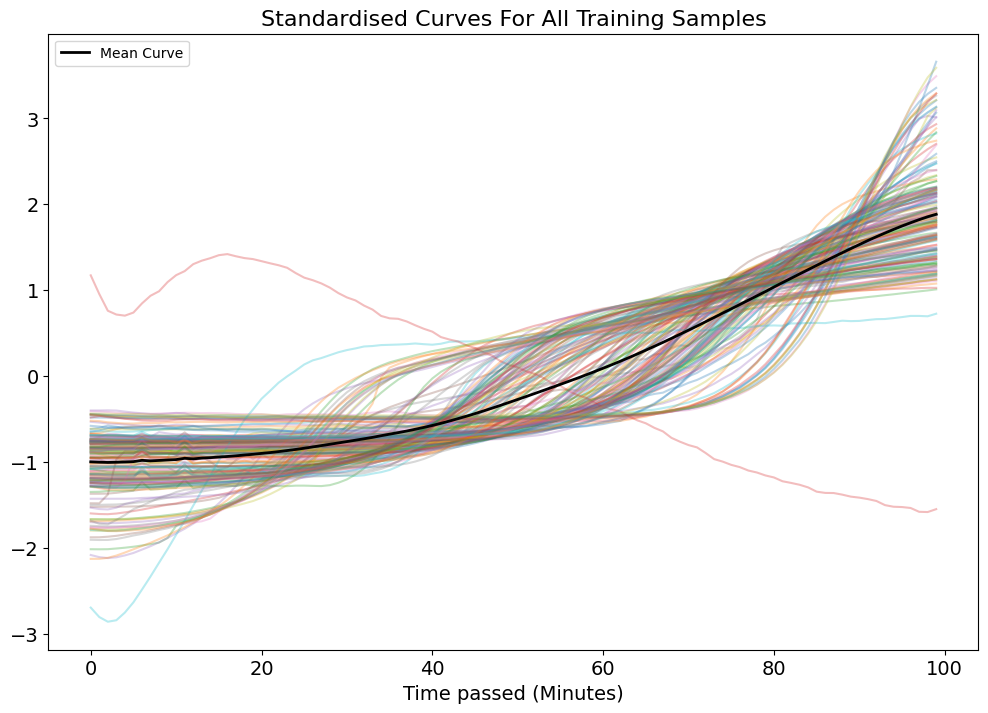

In [112]:
covid_sequences_array = np.vstack(clean_X_train['timeseries'].values)

covid_mean_curve = np.mean(covid_sequences_array, axis=0)

plt.figure(figsize=(12, 8))
for series in clean_X_train['timeseries']:
    plt.plot(series, alpha=0.3)
plt.plot(covid_mean_curve, color='black', linewidth=2, label='Mean Curve')
plt.legend()
plt.title("Standardised Curves For All Training Samples", fontsize=16)
plt.xlabel('Time passed (Minutes)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### Class distributions

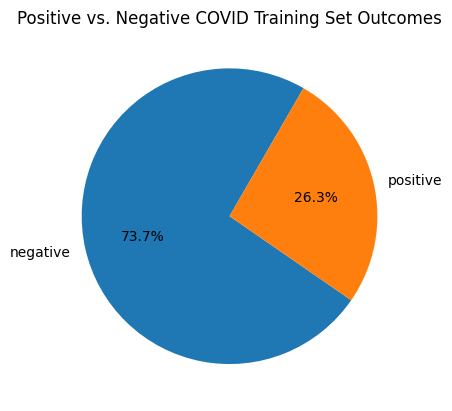

In [73]:
y_train.value_counts().plot.pie(autopct='%1.1f%%',startangle=60)
plt.ylabel('')
plt.title('Positive vs. Negative COVID Training Set Outcomes')
plt.show()

### Mean curves visualisation and dynamic time warping

In [64]:
X_train_positive = X_train[y_train == 'positive']
X_train_negative = X_train[y_train == 'negative']

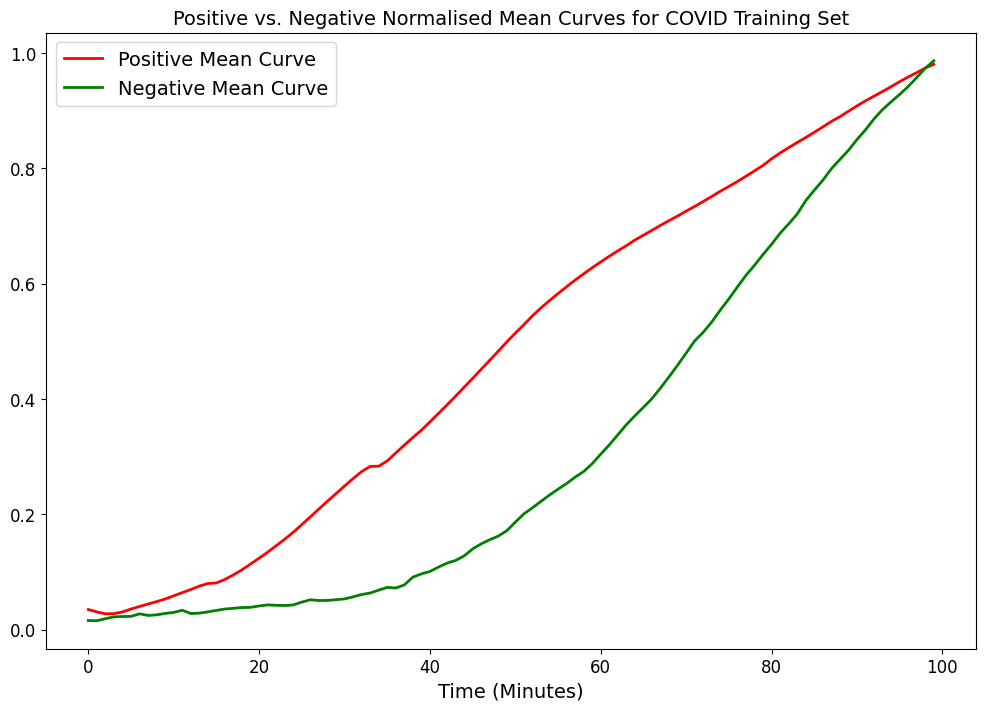

In [127]:
positive_covid_sequences_array = np.vstack(X_train_positive['timeseries'].values)
positive_covid_mean_curve = np.mean(positive_covid_sequences_array, axis=0)

negative_covid_sequences_array = np.vstack(X_train_negative['timeseries'].values)
negative_covid_mean_curve = np.mean(negative_covid_sequences_array, axis=0)

plt.figure(figsize=(12, 8))
plt.plot(positive_covid_mean_curve, color='red', linewidth=2, label='Positive Mean Curve')
plt.plot(negative_covid_mean_curve, color='green', linewidth=2, label='Negative Mean Curve')
plt.legend(fontsize=14)
plt.title("Positive vs. Negative Normalised Mean Curves for COVID Training Set", fontsize=14)
plt.xlabel("Time (Minutes)", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

DTW distance: 0.6933604977378814


Text(0, 0.5, '')

<Figure size 1200x800 with 0 Axes>

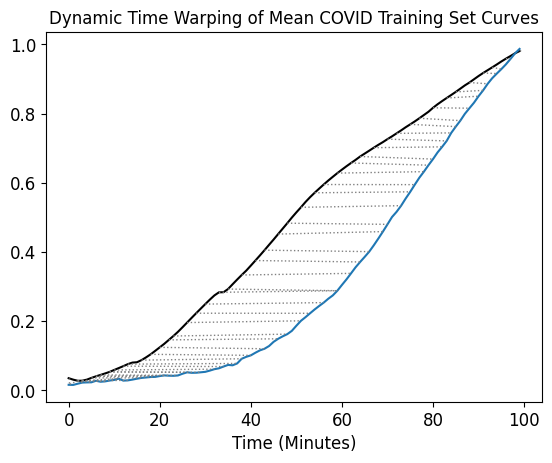

In [128]:
alignment = dtw(positive_covid_mean_curve, negative_covid_mean_curve, keep_internals=True)

print(f"DTW distance: {alignment.distance}")

plt.figure(figsize=(12, 8))
alignment.plot(type="twoway")
plt.title("Dynamic Time Warping of Mean COVID Training Set Curves", fontsize=12)
plt.xlabel("Time (Minutes)", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel("")

## Thresholding Preprocessing

### Outlier Removal

In [6]:
def extract_metrics(series):
    diff = np.diff(series)
    return {
        'std': np.std(series),
        'mean_abs_change': np.mean(np.abs(diff)),
        'autocorr': pd.Series(series).autocorr(lag=1)
    }

metrics_df = pd.DataFrame([
    extract_metrics(ts) for ts in covid_timeseries
])

outlier_flags = (np.abs(zscore(metrics_df)) > 3).any(axis=1)
metric_outliers = metrics_df[outlier_flags]

In [7]:
def total_variation(series):
    return np.sum(np.abs(np.diff(series)))

tv_scores = [total_variation(ts) for ts in covid_timeseries]
variation_threshold = np.percentile(tv_scores, 92) # top 8% most erratic
variation_outlier_indices = [i for i, tv in enumerate(tv_scores) if tv > variation_threshold]

In [8]:
total_outliers = np.array(list(set(metric_outliers.index.values).union(variation_outlier_indices)))
outlier_labels = covid_timeseries.index[total_outliers]

In [9]:
cleaner_covid_timeseries = covid_timeseries.copy()
cleaner_covid_timeseries = cleaner_covid_timeseries.drop(outlier_labels)

In [10]:
print(f"Number of entries of original series: {len(covid_timeseries)}")
print(f"Number of entries of cleaned series: {len(cleaner_covid_timeseries)}")
print(f"Number of entries removed: {len(covid_timeseries)-len(cleaner_covid_timeseries)}")

Number of entries of original series: 278
Number of entries of cleaned series: 255
Number of entries removed: 23


### Label encoding, data balancing and threshold data splitting

In [11]:
cleaner_covid_timeseries = pd.merge(cleaner_covid_timeseries.to_frame(name='timeseries'),
                         covid_outcomes.to_frame(name='overall_result'), on=['sample'], how='left')

In [12]:
# label encoding
cleaner_covid_timeseries['overall_result'] = cleaner_covid_timeseries['overall_result'].map({"positive":1, "negative":0})

In [13]:
# data balancing
y = cleaner_covid_timeseries['overall_result']
X = cleaner_covid_timeseries.drop('overall_result', axis=1)

X_resampled, y_resampled = RandomUnderSampler(random_state=42).fit_resample(X, y)

In [14]:
# data splitting
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42, stratify=y_train)

## Thresholding

In [15]:
pop, hof, logbook = perform_thresholding(X_train, y_train, index_time_scale=1)

gen	nevals	avg                                          	std                                          
0  	200   	[0.43734043 0.81826087 0.45740981 0.62780065]	[0.36111152 0.20197559 0.36458051 0.1226465 ]
1  	200   	[0.67734043 0.75391304 0.69096207 0.71562673]	[0.23918696 0.19299843 0.25737189 0.09087935]
2  	200   	[0.75180851 0.76445652 0.74728723 0.75813252]	[0.20570493 0.1746963  0.23980472 0.07819297]
3  	200   	[0.73638298 0.81619565 0.75639917 0.77628932]	[0.21619356 0.12970443 0.23063674 0.07238989]
4  	200   	[0.69287234 0.83880435 0.70708372 0.76583834]	[0.25018397 0.12960383 0.25653641 0.08435582]
5  	200   	[0.67234043 0.86619565 0.70925301 0.76926804]	[0.24594493 0.11745364 0.26613702 0.0877292 ]
6  	200   	[0.63914894 0.88054348 0.67464616 0.75984621]	[0.26515487 0.11256163 0.28546423 0.09602192]
7  	200   	[0.59819149 0.8925     0.64261563 0.74534574]	[0.28768426 0.10552321 0.31905085 0.10594248]
8  	200   	[0.54489362 0.9176087  0.58269658 0.73125116]	[0.29780995 0.10

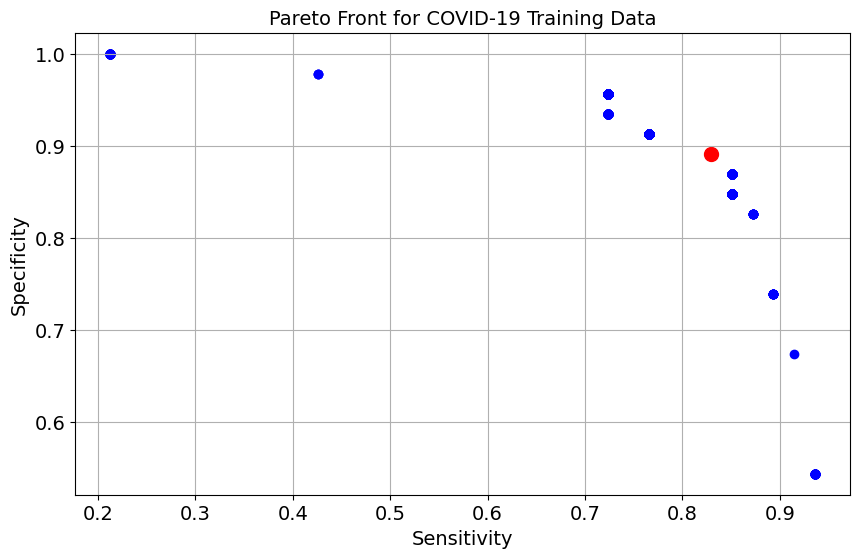

In [16]:
def find_knee_point(hof):
    points = np.array([ind.fitness.values for ind in hof])

    norm_points = (points - points.min(axis=0)) / (points.max(axis=0) - points.min(axis=0))

    dists = distance.cdist(norm_points, np.array([[1, 1, 1, 1]]), 'euclidean')
    knee_idx = np.argmin(dists)

    return hof[knee_idx]

def plot_pareto_front(hof):
    plt.figure(figsize=(10,6))
    sens = [ind.fitness.values[0] for ind in hof]
    spec = [ind.fitness.values[1] for ind in hof]

    plt.scatter(sens, spec, c='blue')
    plt.xlabel("Sensitivity", fontsize=14)
    plt.ylabel("Specificity", fontsize=14)
    plt.title("Pareto Front for COVID-19 Training Data", fontsize=14)
    plt.grid(True)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    knee = find_knee_point(hof)
    plt.scatter([knee.fitness.values[0]], [knee.fitness.values[1]], c='red', s=100)

    plt.show()

plot_pareto_front(hof)
best_solution = find_knee_point(hof)

In [17]:
print("The best criterions are as follows.")
print(f"- Number of bases to include: {best_solution[0]}")
print(f"- Standard deviation: {best_solution[1]}")
print(f"- Classification threshold: {best_solution[2]}")

The best criterions are as follows.
- Number of bases to include: 8
- Standard deviation: 8.723305060702902
- Classification threshold: 21


**Combo list:**
- Used for poster:
    - Number of bases to include: 11
    - Standard deviation: 2.3662428729417875
    - Classification threshold: 13

## Preprocessing

**Note: must run thresholding preprocessing and thresholding beforehand**

### Main features

In [18]:
def extract_arima_features(series: np.ndarray) -> Dict[str, np.ndarray]:
    model = ARIMA(series, order=(1,1,1))
    results = model.fit()

    return {
            'ar_coef': results.arparams[0] if len(results.arparams) > 0 else 0,
            'ma_coef': results.maparams[0] if len(results.maparams) > 0 else 0,
            'resid_mean': results.resid.mean(),
            'resid_std': results.resid.std(),
            'aic': results.aic,
            'hqic': results.hqic,
            }

In [19]:
def get_aggregated_stats(series):
    mean = np.mean(series)
    std = np.std(series)
    median = np.median(series)
    q3 = np.percentile(series, 75)
    q1 = np.percentile(series, 25)
    iqr = q3 - q1
    skew_val = skew(series)
    kurtosis_val = kurtosis(series)
    spectral_entropy = entropy(np.abs(np.fft.fft(series)))
    trend_slope = linregress(np.arange(len(series)), series).slope
    max_jump = np.max(np.abs(np.diff(series)))
    return mean, std, median, iqr, skew_val, kurtosis_val, spectral_entropy, max_jump

In [20]:
def get_mean_averages(series, cutoff=10, which='both'):
    early = series[:cutoff]
    after = series[cutoff:]
    early_mean = np.mean(early)
    after_mean = np.mean(after)

    if which == 'both':
        return early_mean, after_mean
    elif which == 'early':
        return early_mean
    elif which == 'after':
        return after_mean

In [21]:
def get_dynamic_signalling(series, mean_cutoff=10):
    max_index = np.argmax(series)
    auc = np.trapz(series, dx=0.5)
    early_mean, after_mean = get_mean_averages(series, mean_cutoff)
    if len(series) > 1:
      autocorr_lag1 = np.corrcoef(series[:-1], series[1:])[0,1]
    else:
      autocorr_lag1 = np.nan # Handle cases where autocorrelation cannot be calculated
    mean_abs_change = np.mean(np.abs(np.diff(series)))
    mean_change = np.mean(np.diff(series))
    second_deriv = np.diff(series, n=2)
    inflection_index = np.argmax(second_deriv)
    first_deriv = np.diff(series)
    max_growth = np.max(first_deriv)
    time_to_half = np.argmax(series >= 0.5)
    return max_index, auc, early_mean, after_mean, autocorr_lag1, mean_abs_change, mean_change, inflection_index, max_growth, time_to_half

In [22]:
def extract_features_from_series(multi_series, mean_cutoff=10):
    grouped = multi_series.groupby(level='sample')

    feature_rows = []
    index_tuples = []

    for sample, group_series in grouped:
        flattened = np.array(group_series.iloc[0])

        agg_stats = get_aggregated_stats(flattened)
        dyn_signals = get_dynamic_signalling(flattened, mean_cutoff)

        all_features = list(agg_stats) + list(dyn_signals)
        feature_rows.append(all_features)
        index_tuples.append(sample)

    feature_names = [
        "mean", "std", "median", "iqr", "skew", "kurtosis",
        "spectral_entropy", "max_jump",
        "max_index", "auc", "early_mean", "after_mean",
        "autocorr_lag1", "mean_abs_change", "mean_change",
        "inflection_index", "max_growth", "time_to_half"
    ]

    features_df = pd.DataFrame(feature_rows, columns=feature_names, index=index_tuples)
    features_df.index.name = 'sample'

    return features_df

In [23]:
arima_features = pd.DataFrame([extract_arima_features(ts) for ts in cleaner_covid_timeseries['timeseries'].values])
arima_features.index = cleaner_covid_timeseries.index

/home/alex/.conda/envs/general-stuff/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alex/.conda/envs/general-stuff/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alex/.conda/envs/general-stuff/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alex/.conda/envs/general-stuff/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/al

In [24]:
features_df = extract_features_from_series(cleaner_covid_timeseries['timeseries'], mean_cutoff=42)

In [25]:
features_df = pd.merge(features_df, cleaner_covid_timeseries, on='sample')

In [26]:
features_df['meets_threshold'] = get_thresholding_values(features_df.copy(), best_solution[2], features_df['overall_result'], num_base_count=best_solution[0], sigma_multiplier=best_solution[1], index_time_scale=1)['meets_threshold']

**Combining ARIMA**

In [27]:
features_df = pd.merge(features_df, arima_features, on='sample', how='left')

### Adding kNN predictions - model stacking

In [28]:
def dtw_distance(x, y):
    x = np.array(x, dtype=float)
    y = np.array(y, dtype=float)
    alignment = dtw(x, y, distance_only=True)
    return alignment.distance

In [219]:
knn_X = cleaner_covid_timeseries.drop(columns=['overall_result'])
knn_y = cleaner_covid_timeseries['overall_result']

knn_X_resampled, knn_y_resampled = RandomUnderSampler(random_state=42).fit_resample(knn_X, knn_y)

In [220]:
knn_X_train, knn_X_test, knn_y_train, knn_y_test = train_test_split(knn_X_resampled, knn_y_resampled, test_size=0.2, random_state=42, stratify = knn_y_resampled)
knn_X_train, knn_X_val, knn_y_train, knn_y_val = train_test_split(knn_X_train, knn_y_train, test_size=0.125, random_state=42, stratify = knn_y_train)

In [221]:
knn_X_train_array = [ts[0] for ts in knn_X_train.values]
knn_X_val_array = [ts[0] for ts in knn_X_val.values]
knn_X_test_array = [ts[0] for ts in knn_X_test.values]

In [32]:
knn = KNeighborsClassifier(
    n_neighbors=3,
    metric=dtw_distance,
    algorithm='brute'
)

knn.fit(knn_X_train_array, knn_y_train)

print(classification_report(knn.predict(knn_X_train_array), knn_y_train))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90        45
           1       0.94      0.88      0.91        51

    accuracy                           0.91        96
   macro avg       0.91      0.91      0.91        96
weighted avg       0.91      0.91      0.91        96



#### K hyperparameter optimisation using the Elbow method

In [46]:
k_range = range(1, 30)
scores = [cross_val_score(KNeighborsClassifier(n_neighbors=k, metric=dtw_distance, algorithm='brute'), knn_X_train_array,
                          knn_y_train, cv=5).mean() for k in k_range]

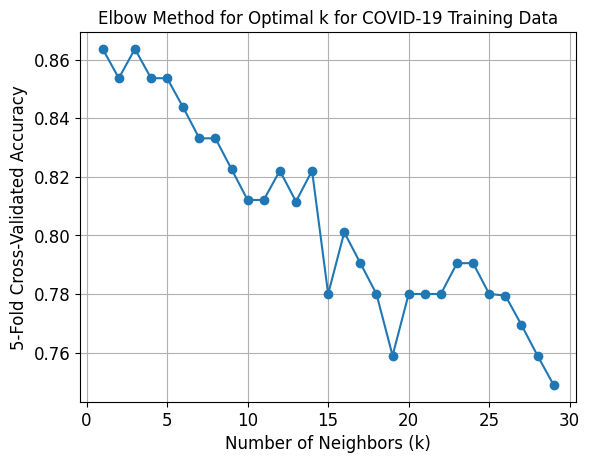

In [71]:
plt.plot(k_range, scores, marker='o')
plt.xlabel('Number of Neighbors (k)', fontsize=12)
plt.ylabel('5-Fold Cross-Validated Accuracy', fontsize=12)
plt.title('Elbow Method for Optimal k for COVID-19 Training Data', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()

In [222]:
knn = KNeighborsClassifier(
    n_neighbors=5,
    metric=dtw_distance,
    algorithm='brute'
)

knn.fit(knn_X_train_array, knn_y_train)

print(classification_report(knn.predict(knn_X_train_array), knn_y_train))

              precision    recall  f1-score   support

           0       0.90      0.91      0.91        47
           1       0.92      0.90      0.91        49

    accuracy                           0.91        96
   macro avg       0.91      0.91      0.91        96
weighted avg       0.91      0.91      0.91        96



In [223]:
print("Classification report for training data:")
print(classification_report(knn_y_train, knn.predict(knn_X_train_array)))
print("Training ROC-AUC score:", roc_auc_score(knn_y_train, knn.predict(knn_X_train_array)), end='\n\n')

print("Classification report for validation data:\n")
print(classification_report(knn_y_val, knn.predict(knn_X_val_array)))
print("Validation ROC-AUC score:", roc_auc_score(knn_y_val, knn.predict(knn_X_val_array)), end='\n\n')

print("Classification report for validation data:\n")
print(classification_report(knn_y_test, knn.predict(knn_X_test_array)))
print("Validation ROC-AUC score:", roc_auc_score(knn_y_test, knn.predict(knn_X_test_array)), end='\n\n')

Classification report for training data:
              precision    recall  f1-score   support

           0       0.91      0.90      0.91        48
           1       0.90      0.92      0.91        48

    accuracy                           0.91        96
   macro avg       0.91      0.91      0.91        96
weighted avg       0.91      0.91      0.91        96

Training ROC-AUC score: 0.90625

Classification report for validation data:

              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       1.00      0.86      0.92         7

    accuracy                           0.93        14
   macro avg       0.94      0.93      0.93        14
weighted avg       0.94      0.93      0.93        14

Validation ROC-AUC score: 0.9285714285714286

Classification report for validation data:

              precision    recall  f1-score   support

           0       0.91      0.71      0.80        14
           1       0.76      

#### Integrating results back into features

In [36]:
gen_y = features_df['overall_result']
gen_X = features_df.drop('overall_result', axis=1)
gen_X_resampled, gen_y_resampled = RandomUnderSampler(random_state=42).fit_resample(gen_X, gen_y)

In [37]:
knn_X_resampled_array = [ts[0] for ts in knn_X_resampled.values]
knn_probs = knn.predict_proba(knn_X_resampled_array)
knn_probs_df = pd.DataFrame(knn_probs, columns=[f'knn_prob_{i}' for i in range(knn_probs.shape[1])])
knn_probs_df.index = knn_X_resampled.index
gen_X_resampled = pd.merge(gen_X_resampled, knn_probs_df, on='sample', how='left')

### Feature engineering

#### Correlation analysis - verifying whether normality is present

In [74]:
results = []

for feature in gen_X_resampled.drop(columns=['timeseries', 'knn_prob_0', 'knn_prob_1', 'meets_threshold']).columns:
    statistic, p_value = shapiro(features_df[feature])
    normally_distributed = p_value > 0.05

    results.append({
        'Feature': feature,
        'P-value (4 d.p.)': round(p_value, 4),
        'Normally Distributed': normally_distributed
    })

distribution_df = pd.DataFrame(results)

distribution_df

,Feature,P-value (4 d.p.),Normally Distributed
0,mean,0.0000,False
1,std,0.0000,False
2,median,0.0000,False
3,iqr,0.0000,False
4,skew,0.0470,False
5,kurtosis,0.0000,False
6,spectral_entropy,0.0001,False
7,max_jump,0.0000,False
8,max_index,0.0000,False
9,auc,0.0000,False


#### Correlation analysis heatmap

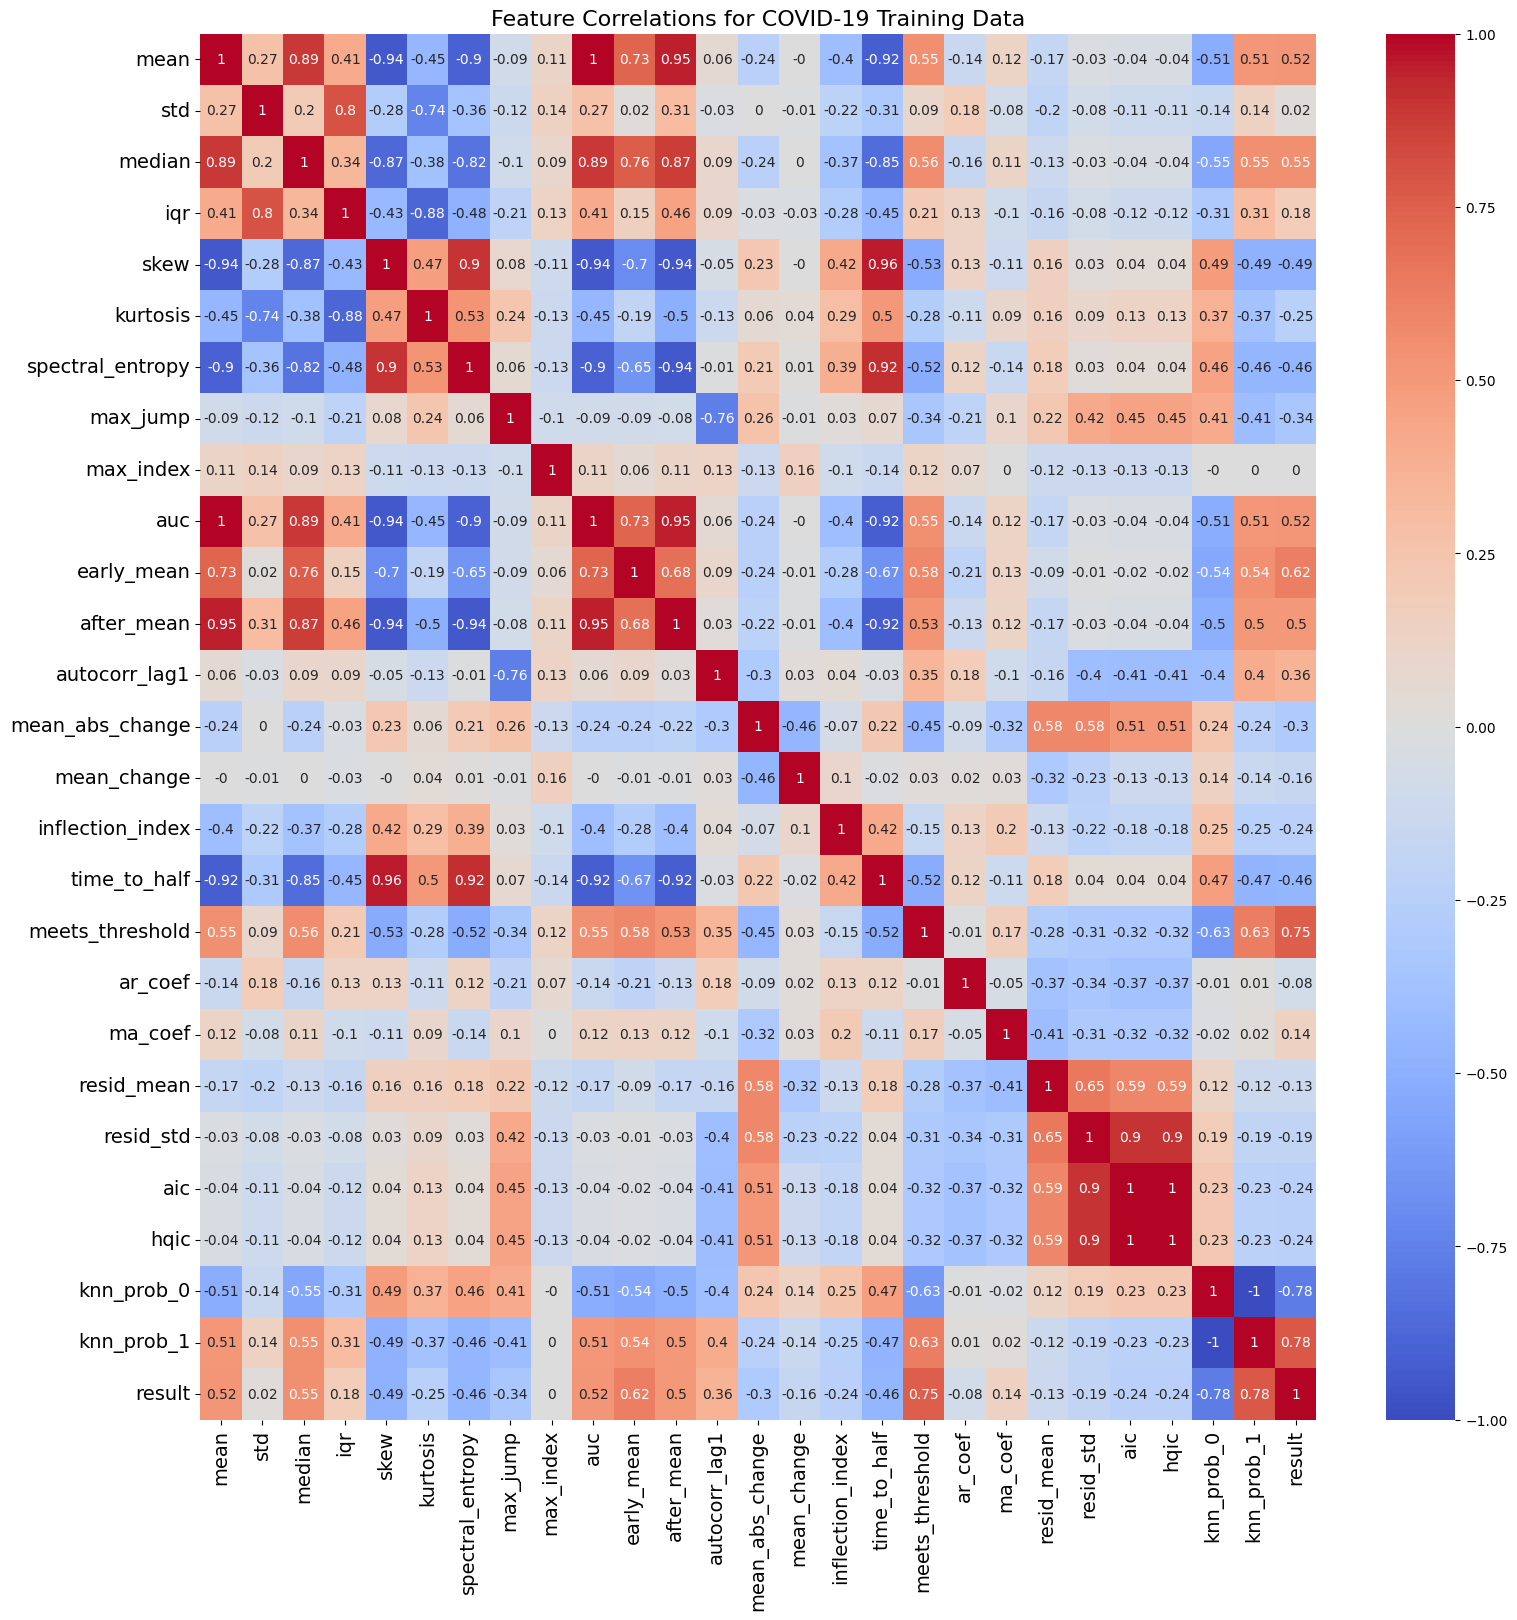

In [101]:
tmp_features = gen_X_resampled.copy()
tmp_features['result'] = gen_y_resampled
tmp_features.drop(columns=['timeseries', 'max_growth'], inplace=True, axis=1)
corr_matrix = tmp_features.corr(method='kendall').round(2)
target_column = 'result'

plt.figure(figsize=(18, 18))
target_corr = corr_matrix[[target_column]].sort_values(by=target_column, ascending=False)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title(f"Feature Correlations for COVID-19 Training Data", fontsize=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.show()

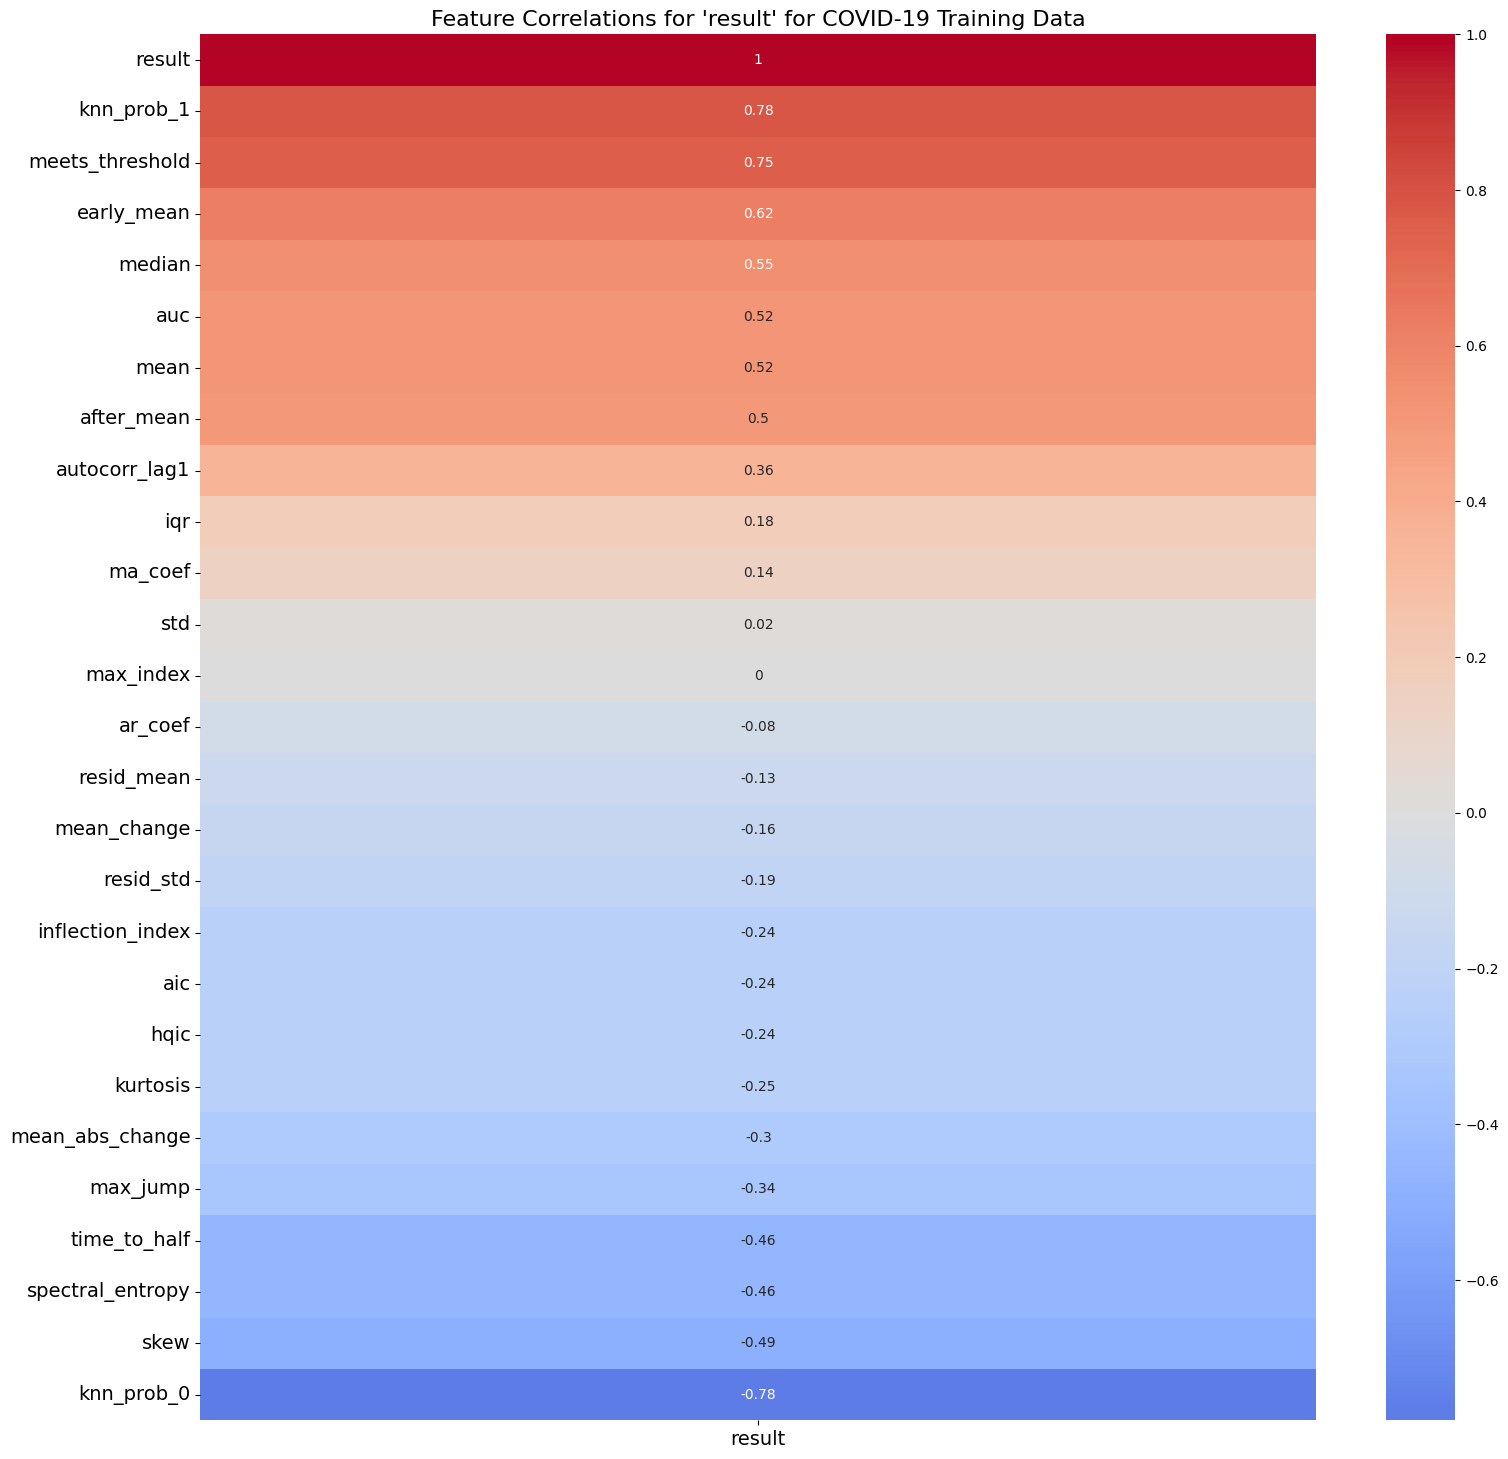

In [102]:
tmp_features = gen_X_resampled.copy()
tmp_features['result'] = gen_y_resampled
tmp_features.drop(columns=['timeseries', 'max_growth'], inplace=True, axis=1)
corr_matrix = tmp_features.corr(method='kendall').round(2)
target_column = 'result'

plt.figure(figsize=(18, 18))
target_corr = corr_matrix[[target_column]].sort_values(by=target_column, ascending=False)
sns.heatmap(target_corr, annot=True, cmap='coolwarm', center=0)
plt.title(f"Feature Correlations for 'result' for COVID-19 Training Data", fontsize=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.show()

#### Final data splitting

In [200]:
# initial feature removal based on correlation and mutual info gain
gen_X_final = gen_X_resampled.drop(columns=['timeseries', 'std', 'max_index', 'kurtosis', 'resid_mean', 'ar_coef', 'ma_coef', 'iqr',
                                            'resid_std', 'aic', 'hqic', 'mean_change', 'mean_abs_change', 'max_growth', 'max_jump', 'knn_prob_1'])

# for optimum cutoff for early_mean and after_mean 
# gen_X_final = gen_X_resampled[['timeseries', 'mean']]

# for mutual info gain analysis
# gen_X_final = gen_X_resampled.drop(columns=['timeseries'])

# recursive feature reduction strategy
gen_X_final = gen_X_resampled.drop(columns=['timeseries', 'knn_prob_1',
                                           'knn_prob_0', 'inflection_index', 'mean_change', 'kurtosis',
                                           'max_index', 'std', 'mean_abs_change', 'autocorr_lag1',
                                           'spectral_entropy', 'max_jump', 'ma_coef', 'ar_coef', 'resid_std', 'resid_mean', 'max_growth', 'aic', 'hqic'])

gen_X_final.columns

Index(['mean', 'median', 'iqr', 'skew', 'auc', 'early_mean', 'after_mean',
       'time_to_half', 'meets_threshold'],
      dtype='object')

In [201]:
X_train, X_test, y_train, y_test = train_test_split(gen_X_final, gen_y_resampled, test_size=0.2, random_state=42, stratify = gen_y_resampled)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42, stratify = y_train)

#### Mutual Information Gain analysis

In [92]:
mi_scores = mutual_info_classif(X_train, y_train, random_state=42)
mi_series = pd.Series(mi_scores, index=X_train.columns).sort_values(ascending=False)
mi_series

early_mean         0.455935
meets_threshold    0.287796
median             0.239790
mean               0.220468
auc                0.217864
after_mean         0.216774
autocorr_lag1      0.150161
time_to_half       0.134690
dtype: float64

#### Optimising mean cutoff

In [84]:
def optimize_cutoff_golden(X, y, low=1, high=99, tol=2, max_iter=10):
    """
    Golden section search for cutoff optimization
    """
    gr = (np.sqrt(5) - 1) / 2  # golden ratio
    
    a, b = low, high
    c = b - gr * (b - a)
    d = a + gr * (b - a)
    
    tested = {}
    
    for i in range(max_iter):
        if abs(c - d) < tol:
            break
            
        for cutoff in [int(round(c)), int(round(d))]:
            if cutoff not in tested:
                X['early_mean'] = X['timeseries'].apply(partial(get_mean_averages, cutoff=cutoff, which='early'))
                X['after_mean'] = X['timeseries'].apply(partial(get_mean_averages, cutoff=cutoff, which='after'))
                X_no_timeseries = X.drop(columns=['timeseries'], axis=1)
                model = RandomForestClassifier(random_state=42)
                scores = cross_val_score(model, X_no_timeseries, y, cv=5, scoring='accuracy')
                tested[cutoff] = np.mean(scores)
        
        if tested[int(round(c))] > tested[int(round(d))]:
            b = d
        else:
            a = c
            
        c = b - gr * (b - a)
        d = a + gr * (b - a)
    
    best_cutoff = max(tested, key=tested.get)
    return best_cutoff, tested[best_cutoff]

In [85]:
best_cutoff, best_score = optimize_cutoff_golden(X_train, y_train)
print(f"Optimal cutoff: {best_cutoff}, Accuracy: {best_score:.4f}")

Optimal cutoff: 42, Accuracy: 0.9158


## Model Development

In [114]:
def train_model(model, param_grid, X_train, y_train, X_val, y_val, X_test, y_test, evaluate_test=False):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=skf,
        scoring='accuracy',
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)

    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validation score:", grid_search.best_score_, end='\n\n')

    best_model = grid_search.best_estimator_

    print("Classification report for training data:")
    print(classification_report(y_train, best_model.predict(X_train)))
    print("Training ROC-AUC score:", roc_auc_score(y_train, best_model.predict(X_train)), end='\n\n')

    print("Classification report for validation data:\n")
    print(classification_report(y_val, best_model.predict(X_val)))
    print("Validation ROC-AUC score:", roc_auc_score(y_val, best_model.predict(X_val)), end='\n\n')
    
    if evaluate_test:
        print("Classification report for testing data:\n")
        print(classification_report(y_test, best_model.predict(X_test)))
        print("Testing ROC-AUC score:", roc_auc_score(y_test, best_model.predict(X_test)), end='\n\n')

    return best_model

### Hyperparameter tuning - Decision Tree

In [217]:
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

tree_clf = DecisionTreeClassifier(random_state=42)

best_dt = train_model(tree_clf, param_grid, X_train, y_train, X_val, y_val, X_test, y_test, evaluate_test=True)

Best parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 10}
Best cross-validation score: 0.9273684210526316

Classification report for training data:
              precision    recall  f1-score   support

           0       0.96      0.90      0.92        48
           1       0.90      0.96      0.93        48

    accuracy                           0.93        96
   macro avg       0.93      0.93      0.93        96
weighted avg       0.93      0.93      0.93        96

Training ROC-AUC score: 0.9270833333333334

Classification report for validation data:

              precision    recall  f1-score   support

           0       0.78      1.00      0.88         7
           1       1.00      0.71      0.83         7

    accuracy                           0.86        14
   macro avg       0.89      0.86      0.85        14
weighted avg       0.89      0.86      0.85        14

Validation ROC-AUC score: 0.8571428571428572

Classification repo

#### Explainability and uncertainity

**Visualising the decision tree**

In [ ]:
dot_data = export_graphviz(
    best_dt,
    out_file=None,
    feature_names=X_train.columns,
    class_names=['negative', 'positive'],
    filled=True,
    rounded=True,
    special_characters=True
)

graph = graphviz.Source(dot_data)
# graph.render("decision_tree")  # Saves as PDF or PNG
graph.view()

**In-built feature importantance**

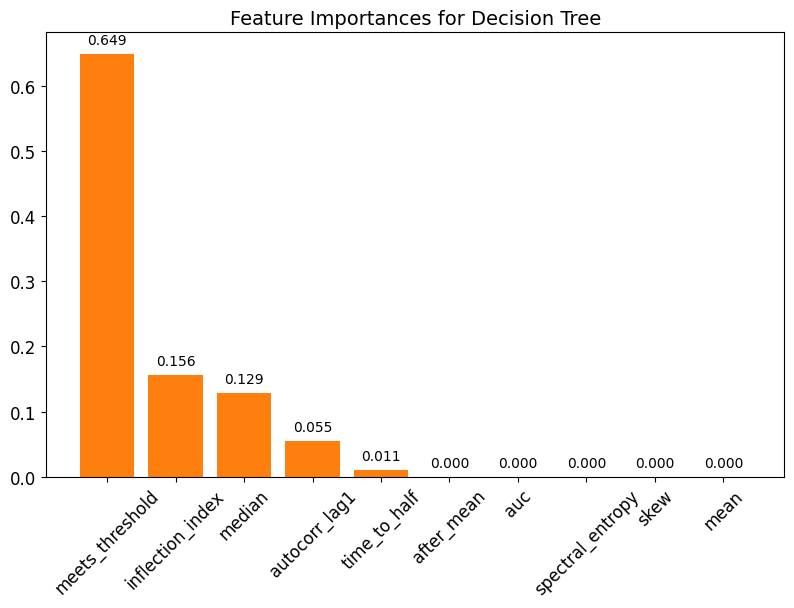

In [78]:
dt_importances = best_dt.feature_importances_
feature_names = X_train.columns

indices = np.argsort(dt_importances)[::-1]

plt.figure(figsize=(8, 6))
plt.title("Feature Importances for Decision Tree", fontsize=14)
plt.bar(range(X_train.shape[1]), dt_importances[indices], align="center")
bars = plt.bar(range(X_train.shape[1]), dt_importances[indices], align="center")
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(i, height + 0.01, f"{height:.3f}", ha='center', va='bottom', fontsize=10)

plt.xticks(range(X_train.shape[1]), [feature_names[i] for i in indices], rotation=45)
plt.tight_layout()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

**Permutation importance**

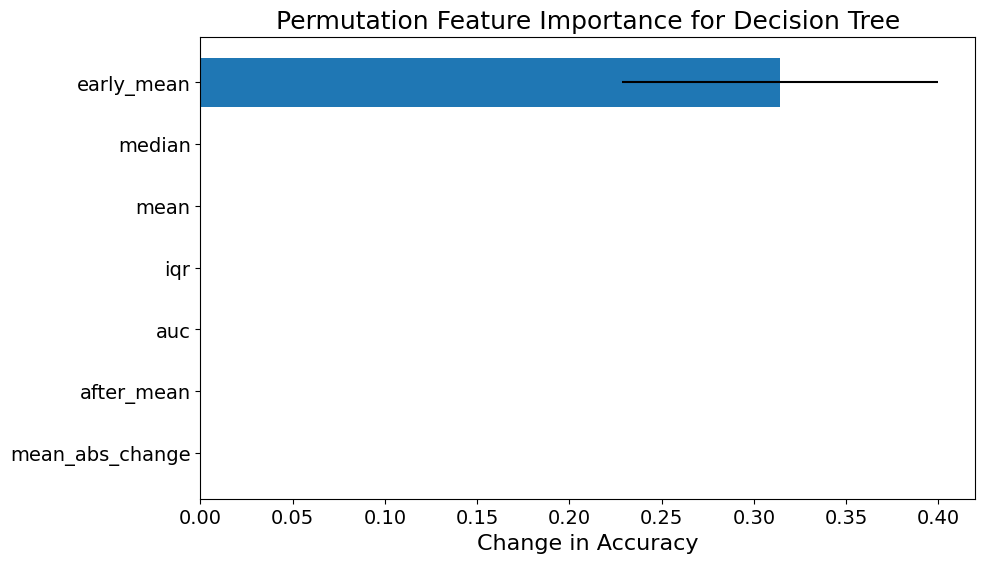

In [172]:
result = permutation_importance(best_dt, X_val, y_val, n_repeats=10, random_state=42)

importance_df = pd.DataFrame({
    'Feature': X_val.columns,
    'Importance': result.importances_mean,
    'Std': result.importances_std
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], xerr=importance_df['Std'])
plt.gca().invert_yaxis()
plt.title("Permutation Feature Importance for Decision Tree", fontsize=18)
plt.xlabel("Change in Accuracy", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

**Partial dependency plots**

In [ ]:
features_to_visualise = ['knn_prob_0', 'knn_prob_1', 'aic', 'max_growth', 'mean_change', 'iqr',
       'std']

for feature in features_to_visualise:
    fig, ax = plt.subplots(figsize=(6, 4))
    PartialDependenceDisplay.from_estimator(
        best_rf,
        X_val,
        features=[feature],
        kind='average',
        grid_resolution=50,
        ax=ax
    )
    plt.tight_layout()
    plt.show()

### Hyperparameter tuning - Random Forest

In [206]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.5, 0.8]
}

rf_tree_clf = RandomForestClassifier(random_state=42)

best_rf = train_model(rf_tree_clf, param_grid, X_train, y_train, X_val, y_val, X_test, y_test, evaluate_test=True)

Best parameters: {'max_depth': 5, 'max_features': 0.8, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Best cross-validation score: 0.9268421052631579

Classification report for training data:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        48
           1       0.96      0.96      0.96        48

    accuracy                           0.96        96
   macro avg       0.96      0.96      0.96        96
weighted avg       0.96      0.96      0.96        96

Training ROC-AUC score: 0.9583333333333335

Classification report for validation data:

              precision    recall  f1-score   support

           0       0.78      1.00      0.88         7
           1       1.00      0.71      0.83         7

    accuracy                           0.86        14
   macro avg       0.89      0.86      0.85        14
weighted avg       0.89      0.86      0.85        14

Validation ROC-AUC score: 0.8571428571428572



#### Explainability and uncertainty

**In-built feature importance**

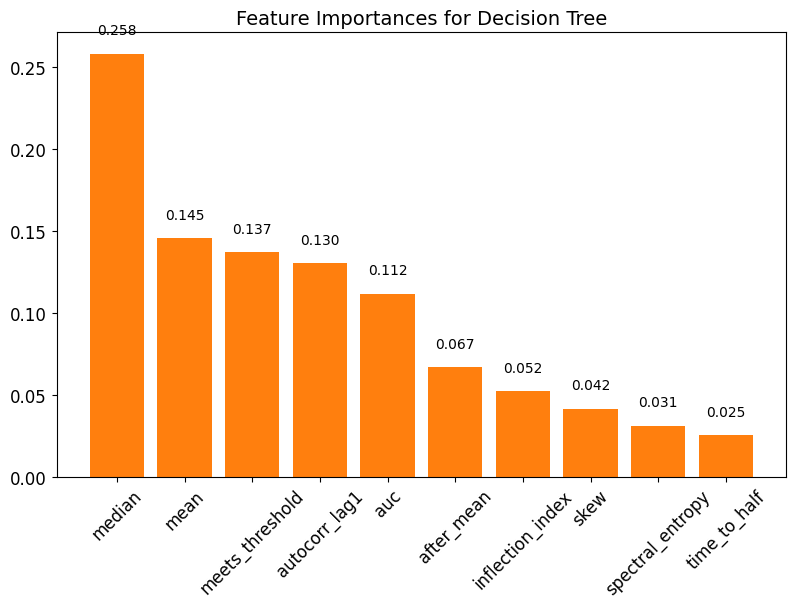

In [81]:
rf_importances = best_rf.feature_importances_
feature_names = X_train.columns

indices = np.argsort(rf_importances)[::-1]

plt.figure(figsize=(8, 6))
plt.title("Feature Importances for Decision Tree", fontsize=14)
plt.bar(range(X_train.shape[1]), rf_importances[indices], align="center")
bars = plt.bar(range(X_train.shape[1]), rf_importances[indices], align="center")
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(i, height + 0.01, f"{height:.3f}", ha='center', va='bottom', fontsize=10)

plt.xticks(range(X_train.shape[1]), [feature_names[i] for i in indices], rotation=45)
plt.tight_layout()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

**Permutation importance**

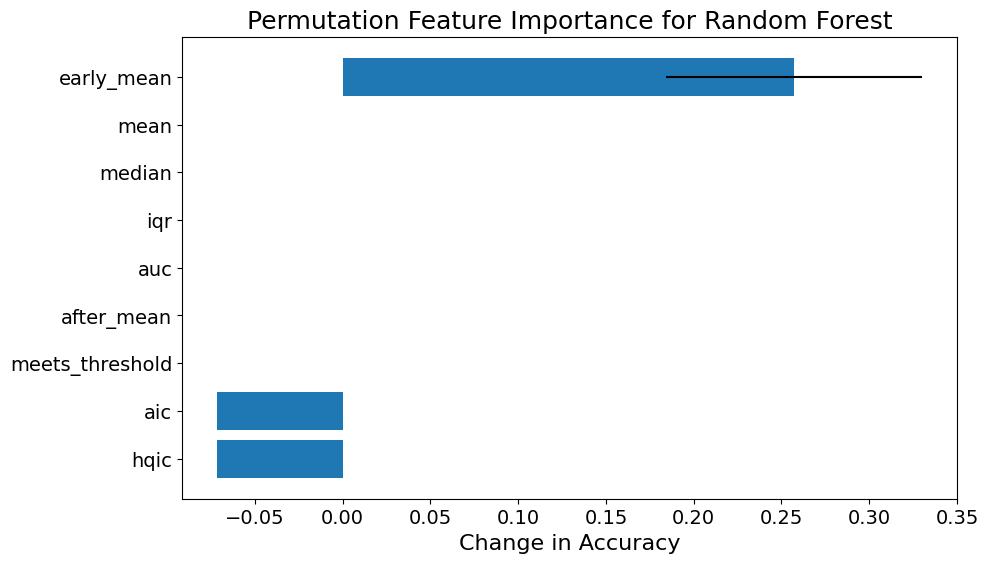

In [199]:
result = permutation_importance(best_rf, X_val, y_val, n_repeats=10, random_state=42)

importance_df = pd.DataFrame({
    'Feature': X_val.columns,
    'Importance': result.importances_mean,
    'Std': result.importances_std
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], xerr=importance_df['Std'])
plt.gca().invert_yaxis()
plt.title("Permutation Feature Importance for Random Forest", fontsize=18)
plt.xlabel("Change in Accuracy", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

**Partial dependency plots**

In [ ]:
features_to_visualise = ['knn_prob_0', 'knn_prob_1', 'aic', 'max_growth', 'mean_change', 'iqr',
       'std']

for feature in features_to_visualise:
    fig, ax = plt.subplots(figsize=(6, 4))
    PartialDependenceDisplay.from_estimator(
        best_rf,
        X_val,
        features=[feature],
        kind='average',
        grid_resolution=50,
        ax=ax
    )
    plt.tight_layout()
    plt.show()

#### Visuals

In [53]:
class_names = ['Negative', 'Positive']
cm = confusion_matrix(y_test, best_rf.predict(X_test))

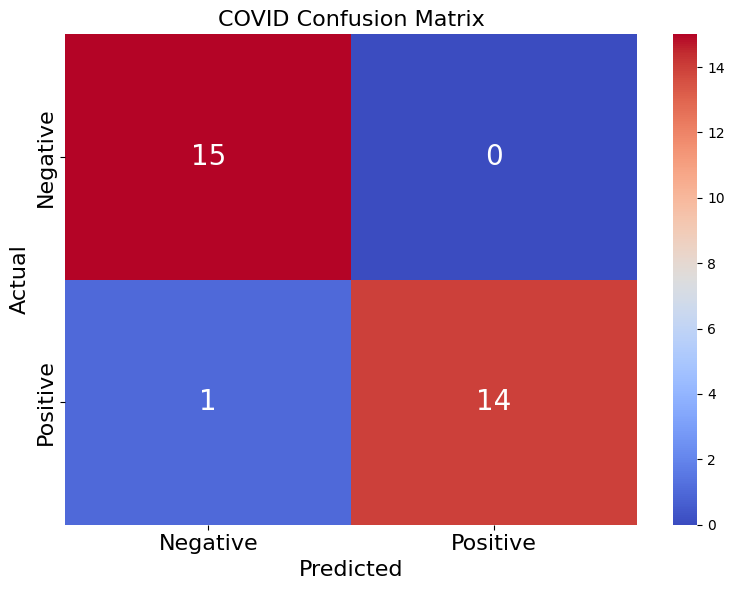

In [59]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=class_names, yticklabels=class_names,
           annot_kws={"size": 20})
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('Actual', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('COVID Confusion Matrix', fontsize=16)
plt.tight_layout()
plt.show()

In [57]:
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
scores = cross_val_score(best_rf, X_train, y_train, cv=rskf)

print("Mean accuracy:", scores.mean())
print("Std deviation:", scores.std())

Mean accuracy: 0.8741428571428571
Std deviation: 0.06975663883912067


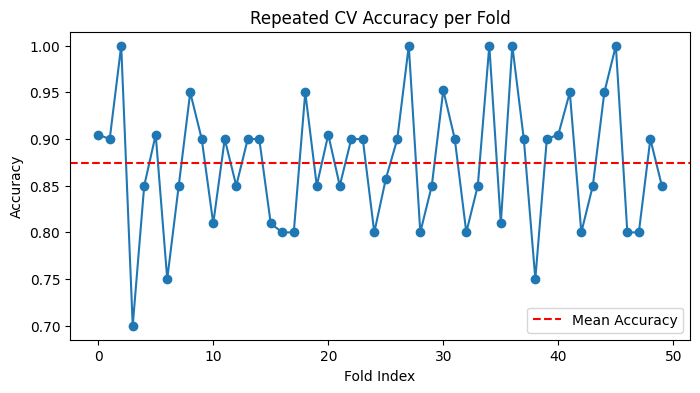

In [58]:
plt.figure(figsize=(8, 4))
plt.plot(scores, marker='o')
plt.axhline(y=scores.mean(), color='r', linestyle='--', label='Mean Accuracy')
plt.title("Repeated CV Accuracy per Fold")
plt.xlabel("Fold Index")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Hyperparameter tuning - XGBoost

In [207]:
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'min_child_weight': [1, 3, 5]
}

xgboost_model = xgb.XGBClassifier(eval_metric='logloss', random_state=42)

best_xgb = train_model(xgboost_model, param_grid, X_train, y_train, X_val, y_val, X_test, y_test, evaluate_test=True)

Best parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 0.8}
Best cross-validation score: 0.9273684210526316

Classification report for training data:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        48
           1       1.00      0.98      0.99        48

    accuracy                           0.99        96
   macro avg       0.99      0.99      0.99        96
weighted avg       0.99      0.99      0.99        96

Training ROC-AUC score: 0.9895833333333333

Classification report for validation data:

              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       1.00      0.86      0.92         7

    accuracy                           0.93        14
   macro avg       0.94      0.93      0.93        14
weighted avg       0.94      0.93      0.93        14

Validation RO

### Hyperparameter tuning - kNN

In [208]:
param_grid = {
    'n_neighbors': list(range(1, 21)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1, 2]  # Only used with 'minkowski'
}

knn_clf = KNeighborsClassifier()

best_knn = train_model(knn_clf, param_grid, X_train, y_train, X_val, y_val, X_test, y_test, evaluate_test=True)

Best parameters: {'metric': 'manhattan', 'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
Best cross-validation score: 0.8536842105263158

Classification report for training data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        48
           1       1.00      1.00      1.00        48

    accuracy                           1.00        96
   macro avg       1.00      1.00      1.00        96
weighted avg       1.00      1.00      1.00        96

Training ROC-AUC score: 1.0

Classification report for validation data:

              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       1.00      0.86      0.92         7

    accuracy                           0.93        14
   macro avg       0.94      0.93      0.93        14
weighted avg       0.94      0.93      0.93        14

Validation ROC-AUC score: 0.9285714285714286

Classification report for testing data:

      

### Hyperparameter tuning - Ridge

In [209]:
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

ridge_clf = RidgeClassifier(random_state=42)

best_ridge = train_model(ridge_clf, param_grid, X_train, y_train, X_val, y_val, X_test, y_test, evaluate_test=True)

Best parameters: {'alpha': 10}
Best cross-validation score: 0.9268421052631579

Classification report for training data:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        48
           1       0.94      0.94      0.94        48

    accuracy                           0.94        96
   macro avg       0.94      0.94      0.94        96
weighted avg       0.94      0.94      0.94        96

Training ROC-AUC score: 0.9375

Classification report for validation data:

              precision    recall  f1-score   support

           0       1.00      0.86      0.92         7
           1       0.88      1.00      0.93         7

    accuracy                           0.93        14
   macro avg       0.94      0.93      0.93        14
weighted avg       0.94      0.93      0.93        14

Validation ROC-AUC score: 0.9285714285714286

Classification report for testing data:

              precision    recall  f1-score   support

       

#### Explainability and interpretability

**Coefficient analysis**

In [229]:
coefficients = best_ridge.coef_  # For binary classification
feature_names = X_train.columns

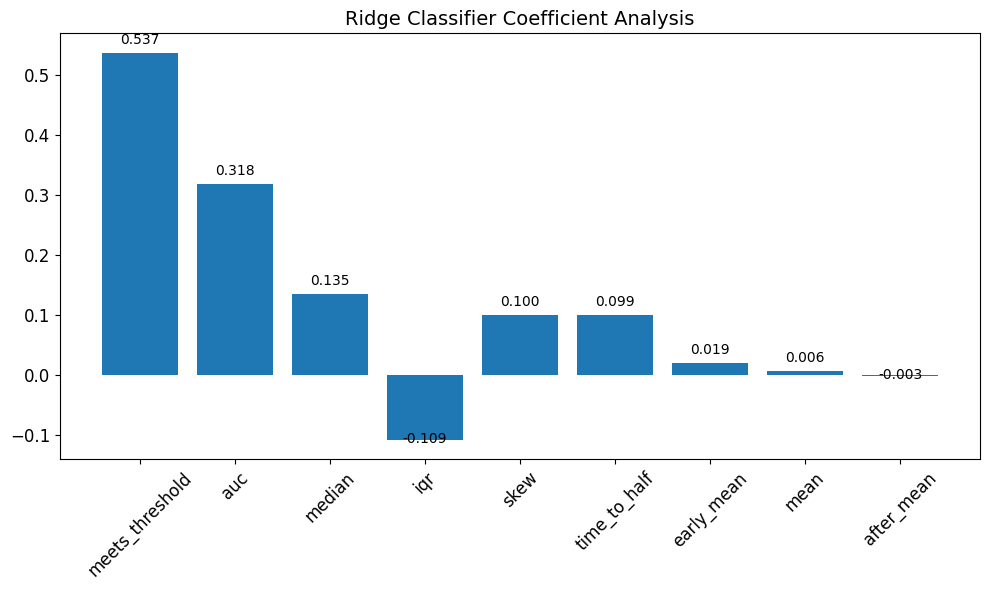

In [230]:
indices = np.argsort(np.abs(coefficients))[::-1]

plt.figure(figsize=(10, 6))
plt.title("Ridge Classifier Coefficient Analysis", fontsize=14)
bars = plt.bar(range(len(coefficients)), coefficients[indices], align='center')
plt.xticks(range(len(coefficients)), [feature_names[i] for i in indices], rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Annotate values
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(i, height + 0.01*np.sign(height), f"{height:.3f}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


**Permutation importance**

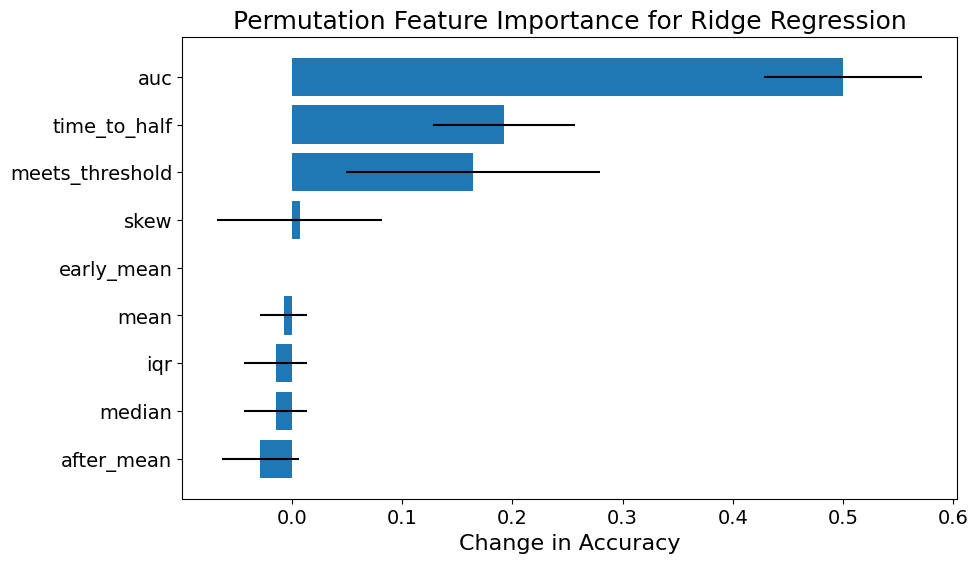

In [231]:
result = permutation_importance(best_ridge, X_val, y_val, n_repeats=10, random_state=42)

importance_df = pd.DataFrame({
    'Feature': X_val.columns,
    'Importance': result.importances_mean,
    'Std': result.importances_std
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], xerr=importance_df['Std'])
plt.gca().invert_yaxis()
plt.title("Permutation Feature Importance for Ridge Regression", fontsize=18)
plt.xlabel("Change in Accuracy", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

**SHAP**

/tmp/ipykernel_10415/735784673.py:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_val)


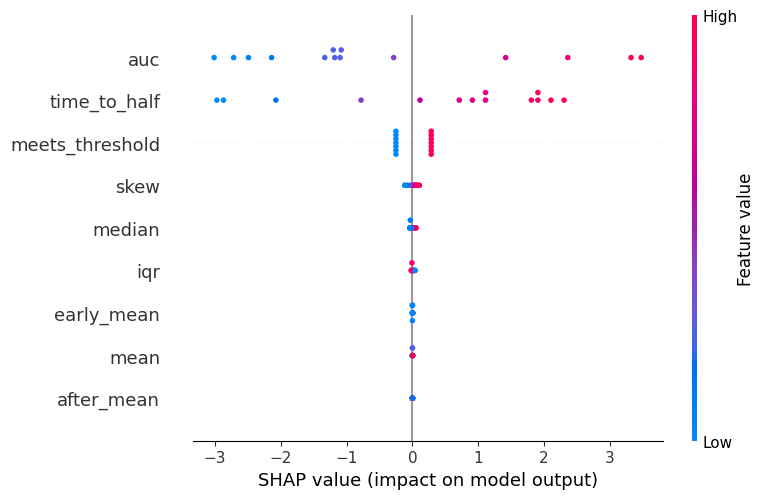

In [234]:
explainer = shap.LinearExplainer(best_ridge, X_train)
shap_values = explainer.shap_values(X_val)
shap.summary_plot(shap_values, X_val)

### Hyperparameter tuning - Logistic

In [210]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['liblinear', 'saga'],
    'class_weight': [None, 'balanced']
}

log_clf = LogisticRegression(random_state=42)

best_log = train_model(log_clf, param_grid, X_train, y_train, X_val, y_val, X_test, y_test, evaluate_test=True)

/home/alex/.conda/envs/general-stuff/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/alex/.conda/envs/general-stuff/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/alex/.conda/envs/general-stuff/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/alex/.conda/envs/general-stuff/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/alex/.conda/envs/general-stuff/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

Best parameters: {'C': 100, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation score: 0.884736842105263

Classification report for training data:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91        48
           1       0.91      0.90      0.91        48

    accuracy                           0.91        96
   macro avg       0.91      0.91      0.91        96
weighted avg       0.91      0.91      0.91        96

Training ROC-AUC score: 0.90625

Classification report for validation data:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         7

    accuracy                           1.00        14
   macro avg       1.00      1.00      1.00        14
weighted avg       1.00      1.00      1.00        14

Validation ROC-AUC score: 1.0

Classification report for testing data:

              prec

#### Explainability

**Permutation importance**

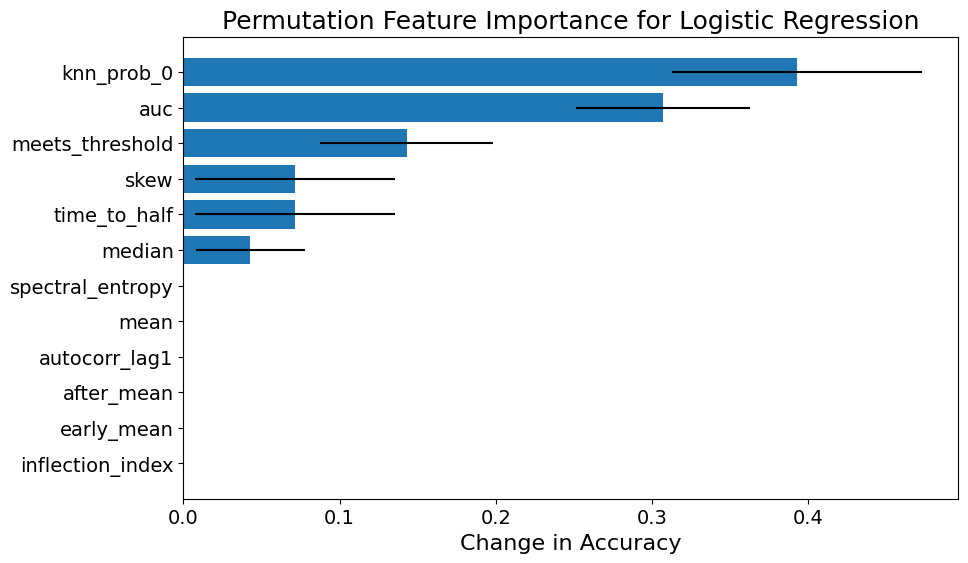

In [156]:
result = permutation_importance(best_log, X_val, y_val, n_repeats=10, random_state=42)

importance_df = pd.DataFrame({
    'Feature': X_val.columns,
    'Importance': result.importances_mean,
    'Std': result.importances_std
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], xerr=importance_df['Std'])
plt.gca().invert_yaxis()
plt.title("Permutation Feature Importance for Logistic Regression", fontsize=18)
plt.xlabel("Change in Accuracy", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### Hyperparameter tuning - SVC

In [211]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'],
    'class_weight': [None, 'balanced']
}

svc_clf = SVC(random_state=42)

best_svc = train_model(svc_clf, param_grid, X_train, y_train, X_val, y_val, X_test, y_test, evaluate_test=True)

Best parameters: {'C': 0.1, 'class_weight': None, 'gamma': 'scale', 'kernel': 'linear'}
Best cross-validation score: 0.9268421052631579

Classification report for training data:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95        48
           1       0.96      0.94      0.95        48

    accuracy                           0.95        96
   macro avg       0.95      0.95      0.95        96
weighted avg       0.95      0.95      0.95        96

Training ROC-AUC score: 0.9479166666666667

Classification report for validation data:

              precision    recall  f1-score   support

           0       0.78      1.00      0.88         7
           1       1.00      0.71      0.83         7

    accuracy                           0.86        14
   macro avg       0.89      0.86      0.85        14
weighted avg       0.89      0.86      0.85        14

Validation ROC-AUC score: 0.8571428571428572

Classification report for testing 

### Voting Classification

In [212]:
voting_clf = VotingClassifier(
    estimators=[('dt', best_dt), ('knn', best_knn), ('logistic', best_log), ('ridge', best_ridge)],
    voting='hard'
)

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('dt',
                              DecisionTreeClassifier(max_depth=3,
                                                     min_samples_leaf=2,
                                                     min_samples_split=10,
                                                     random_state=42)),
                             ('knn',
                              KNeighborsClassifier(metric='manhattan',
                                                   n_neighbors=4, p=1,
                                                   weights='distance')),
                             ('logistic',
                              LogisticRegression(C=100, random_state=42,
                                                 solver='liblinear')),
                             ('ridge',
                              RidgeClassifier(alpha=10, random_state=42))])

In [218]:
print("Classification report for training data:")
print(classification_report(y_train, voting_clf.predict(X_train)))
print("Training ROC-AUC score:", roc_auc_score(y_train, voting_clf.predict(X_train)), end='\n\n')

print("Classification report for validation data:\n")
print(classification_report(y_val, voting_clf.predict(X_val)))
print("Validation ROC-AUC score:", roc_auc_score(y_val, voting_clf.predict(X_val)), end='\n\n')

print("Classification report for validation data:\n")
print(classification_report(y_test, voting_clf.predict(X_test)))
print("Validation ROC-AUC score:", roc_auc_score(y_test, voting_clf.predict(X_test)), end='\n\n')

Classification report for training data:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95        48
           1       0.96      0.94      0.95        48

    accuracy                           0.95        96
   macro avg       0.95      0.95      0.95        96
weighted avg       0.95      0.95      0.95        96

Training ROC-AUC score: 0.9479166666666667

Classification report for validation data:

              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       1.00      0.86      0.92         7

    accuracy                           0.93        14
   macro avg       0.94      0.93      0.93        14
weighted avg       0.94      0.93      0.93        14

Validation ROC-AUC score: 0.9285714285714286

Classification report for validation data:

              precision    recall  f1-score   support

           0       1.00      0.86      0.92        14
           1      

In [214]:
print("Classification report for validation data:\n")
print(classification_report(y_val, voting_clf.predict(X_val)))
print("Validation ROC-AUC score:", roc_auc_score(y_val, voting_clf.predict(X_val)), end='\n\n')

Classification report for validation data:

              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       1.00      0.86      0.92         7

    accuracy                           0.93        14
   macro avg       0.94      0.93      0.93        14
weighted avg       0.94      0.93      0.93        14

Validation ROC-AUC score: 0.9285714285714286



In [215]:
print("Classification report for validation data:\n")
print(classification_report(y_test, voting_clf.predict(X_test)))
print("Validation ROC-AUC score:", roc_auc_score(y_test, voting_clf.predict(X_test)), end='\n\n')

Classification report for validation data:

              precision    recall  f1-score   support

           0       1.00      0.86      0.92        14
           1       0.88      1.00      0.93        14

    accuracy                           0.93        28
   macro avg       0.94      0.93      0.93        28
weighted avg       0.94      0.93      0.93        28

Validation ROC-AUC score: 0.9285714285714286



### Best scores

#### Initial features evaluation

In [145]:
models = {
    'decision_tree': best_dt,
    'random_forest': best_rf,
    'xgboost': best_xgb,
    'knn': best_knn,
    'ridge': best_ridge,
    'logistic': best_log,
    'svc': best_svc
}

results = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    train_acc = round(accuracy_score(y_train, model.predict(X_train)), 3)
    val_acc = round(accuracy_score(y_val, model.predict(X_val)), 3)
    cv_acc = round(cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy').mean(), 3)
    
    results.append({
        'Model': name,
        'Training Accuracy': train_acc,
        'Validation Accuracy': val_acc,
        'Cross-Validation Accuracy': cv_acc
    })

best_accs = pd.DataFrame(results)
best_accs['Training Accuracy'] = best_accs['Training Accuracy']*100
best_accs['Validation Accuracy'] = best_accs['Validation Accuracy']*100
best_accs['Cross-Validation Accuracy'] = best_accs['Cross-Validation Accuracy']*100
best_accs = best_accs.sort_values(by='Validation Accuracy', ascending=False)
best_accs

,Model,Training Accuracy,Validation Accuracy,Cross-Validation Accuracy
4,ridge,95.8,100.0,93.8
5,logistic,94.8,100.0,91.7
1,random_forest,95.8,92.9,93.7
3,knn,100.0,92.9,86.5
2,xgboost,93.8,92.9,93.7
6,svc,94.8,92.9,92.7
0,decision_tree,94.8,85.7,91.7


#### Final test results

In [216]:
models = {
    'decision_tree': best_dt,
    'random_forest': best_rf,
    'xgboost': best_xgb,
    'knn': best_knn,
    'ridge': best_ridge,
    'logistic': best_log,
    'svc': best_svc,
    'voting': voting_clf
}

results = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    train_acc = round(accuracy_score(y_train, model.predict(X_train)), 3)
    val_acc = round(accuracy_score(y_val, model.predict(X_val)), 3)
    test_acc = round(accuracy_score(y_test, model.predict(X_test)), 3)
    cv_acc = round(cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy').mean(), 3)
    
    results.append({
        'Model': name,
        'Training Accuracy': train_acc,
        'Validation Accuracy': val_acc,
        'Testing Accuracy': test_acc,
        'Cross-Validation Accuracy': cv_acc
    })

best_accs = pd.DataFrame(results)
best_accs['Training Accuracy'] = best_accs['Training Accuracy']*100
best_accs['Validation Accuracy'] = best_accs['Validation Accuracy']*100
best_accs['Testing Accuracy'] = best_accs['Testing Accuracy']*100
best_accs['Cross-Validation Accuracy'] = best_accs['Cross-Validation Accuracy']*100
best_accs = best_accs.sort_values(by='Testing Accuracy', ascending=False)
best_accs

,Model,Training Accuracy,Validation Accuracy,Testing Accuracy,Cross-Validation Accuracy
0,decision_tree,92.7,85.7,92.9,92.7
1,random_forest,95.8,85.7,92.9,92.7
2,xgboost,99.0,92.9,92.9,92.7
4,ridge,93.8,92.9,92.9,92.7
7,voting,94.8,92.9,92.9,92.7
6,svc,94.8,85.7,92.9,92.7
5,logistic,90.6,100.0,89.3,88.5
3,knn,100.0,92.9,82.1,85.4
